In [ ]:
# this is copied from flavoringr_word2vec_002

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from ast import literal_eval
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import time

In [3]:
from gensim.models import Word2Vec

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.metrics import accuracy_score

In [46]:
xcf_data=pd.read_csv('~/final_flavour/june_datasets/(14.09)xcf_flavordb_data.csv',index_col=0,converters={'flavordb_ingrs':eval})
ars_data=pd.read_csv('~/final_flavour/june_datasets/(23.09)ars_flavordb_data.csv',index_col=0,converters={'flavordb_ingrs':eval})
kb_data=pd.read_csv('~/final_flavour/june_datasets/(29.06)kb_flavordb_data.csv',index_col=0,converters={'flavordb_ingrs':eval})

In [47]:
print(xcf_data.shape)
print(ars_data.shape)
print(kb_data.shape)

(11821, 2)
(10623, 2)
(9047, 2)


In [48]:
xcf_data=xcf_data.explode('flavordb_ingrs').reset_index(drop=True)
ars_data=ars_data.explode('flavordb_ingrs').reset_index(drop=True)
kb_data=kb_data.explode('flavordb_ingrs').reset_index(drop=True)

In [30]:
# check the frequency 

In [31]:
xcf_ingr_fre=pd.DataFrame(xcf_data['flavordb_ingrs'].value_counts()).reset_index()
xcf_ingr_fre.columns=['flavordb_ingrs','fre']
xcf_ingr_fre.shape

(307, 2)

In [32]:
ars_ingr_fre=pd.DataFrame(ars_data['flavordb_ingrs'].value_counts()).reset_index()
ars_ingr_fre.columns=['flavordb_ingrs','fre']
ars_ingr_fre.shape

(341, 2)

In [33]:
kb_ingr_fre=pd.DataFrame(kb_data['flavordb_ingrs'].value_counts()).reset_index()
kb_ingr_fre.columns=['flavordb_ingrs','fre']
kb_ingr_fre.shape

(356, 2)

In [34]:
xcf_ingr_fre['fre'].describe()

count     307.000000
mean      214.061889
std       634.040539
min         1.000000
25%         6.500000
50%        35.000000
75%       138.500000
max      6060.000000
Name: fre, dtype: float64

In [35]:
ars_ingr_fre['fre'].describe()

count     341.000000
mean      250.739003
std       681.306085
min         1.000000
25%         8.000000
50%        36.000000
75%       170.000000
max      5754.000000
Name: fre, dtype: float64

In [36]:
kb_ingr_fre['fre'].describe()

count     356.000000
mean      242.761236
std       648.714479
min         1.000000
25%         5.000000
50%        28.500000
75%       174.000000
max      5576.000000
Name: fre, dtype: float64

In [37]:
# keep the 90% ingredients of each dataset(start from 90%)

In [49]:
xcf_filter_ingr=xcf_ingr_fre['flavordb_ingrs'][xcf_ingr_fre['fre']>=xcf_ingr_fre['fre'].quantile(0.10)].values.tolist()
ars_filter_ingr=ars_ingr_fre['flavordb_ingrs'][ars_ingr_fre['fre']>=ars_ingr_fre['fre'].quantile(0.10)].values.tolist()
kb_filter_ingr=kb_ingr_fre['flavordb_ingrs'][kb_ingr_fre['fre']>=kb_ingr_fre['fre'].quantile(0.10)].values.tolist()

In [50]:
print("Num. filter ingredient in xcf:", len(xcf_filter_ingr))
print("Num. filter ingredient in ars:", len(ars_filter_ingr))
print("Num. filter ingredient in kb:", len(kb_filter_ingr))

Num. filter ingredient in xcf: 276
Num. filter ingredient in ars: 314
Num. filter ingredient in kb: 324


In [51]:
xcf_filter_ingrs=xcf_data[xcf_data['flavordb_ingrs'].isin(xcf_filter_ingr)]
ars_filter_ingrs=ars_data[ars_data['flavordb_ingrs'].isin(ars_filter_ingr)]
kb_filter_ingrs=kb_data[kb_data['flavordb_ingrs'].isin(kb_filter_ingr)]

In [52]:
xcf_filter_ingrs['origin']=0
ars_filter_ingrs['origin']=1
kb_filter_ingrs['origin']=2

In [53]:
xcf_filter_ingrs=pd.DataFrame(xcf_filter_ingrs.groupby(['origin','recipe_id'])['flavordb_ingrs'].apply(set)).reset_index()
ars_filter_ingrs=pd.DataFrame(ars_filter_ingrs.groupby(['origin','recipe_id'])['flavordb_ingrs'].apply(set)).reset_index()
kb_filter_ingrs=pd.DataFrame(kb_filter_ingrs.groupby(['origin','recipe_id'])['flavordb_ingrs'].apply(set)).reset_index()

In [54]:
xcf_filter_ingrs['flavordb_ingrs']=xcf_filter_ingrs['flavordb_ingrs'].apply(lambda x:sorted(x))
ars_filter_ingrs['flavordb_ingrs']=ars_filter_ingrs['flavordb_ingrs'].apply(lambda x:sorted(x))
kb_filter_ingrs['flavordb_ingrs']=kb_filter_ingrs['flavordb_ingrs'].apply(lambda x:sorted(x))

In [55]:
print(xcf_filter_ingrs.shape)
print(ars_filter_ingrs.shape)
print(kb_filter_ingrs.shape)

(11819, 3)
(10623, 3)
(9047, 3)


In [56]:
all_filter_ingrs=pd.concat([xcf_filter_ingrs,ars_filter_ingrs,kb_filter_ingrs],axis=0).reset_index(drop=True)
all_filter_ingrs.shape

(31489, 3)

In [57]:
recipes_as_sentences=all_filter_ingrs['flavordb_ingrs'].values.tolist()
print(len(recipes_as_sentences))

31489


In [58]:
train_df,test_df,train_y,test_y=train_test_split(all_filter_ingrs['flavordb_ingrs'],all_filter_ingrs['origin'],test_size=0.3,random_state=42)

In [59]:
train_df=pd.DataFrame(train_df).reset_index(drop=True)
test_df=pd.DataFrame(test_df).reset_index(drop=True)

In [60]:
print('Num. data in train set:', train_df.shape)
print('Num. data in test set:', test_df.shape)

Num. data in train set: (22042, 1)
Num. data in test set: (9447, 1)


In [61]:
train_sentences=[]
for sentence in train_df['flavordb_ingrs']:
    train_sentences.append(sentence)

In [62]:
num_features=100     
min_word_count=1  # min_word_count=1 75% of the corpus/min_word_count=3 75% of the corpus
num_workers=1
downsampling = 1e-3


model=Word2Vec(train_sentences,workers=num_workers,
               vector_size=num_features,min_count=min_word_count,sg=0,sample = downsampling)

In [63]:
def get_w2v_features(sentence,model):
    # model_vocabs=set(model.wv.vocab.keys())
    model_vocabs=set(model.wv.key_to_index.keys())
    featureVec = np.zeros(model.vector_size, dtype="float32")
    
    nwords=0
    for word in sentence:
        if word in model_vocabs:
            #featureVec=np.add(featureVec,model[word])
            featureVec=np.add(featureVec,model.wv[word])
            nwords+=1
        else:
            featureVec=featureVec
    if nwords > 0:
        #print(nwords)
        featureVec=np.divide(featureVec,nwords)
    return featureVec

In [64]:
train_df['w2v_features']=list(map(lambda sentence:get_w2v_features(sentence,model),train_df['flavordb_ingrs']))
test_df['w2v_features']=list(map(lambda sentence:get_w2v_features(sentence,model),test_df['flavordb_ingrs']))

In [65]:
train_X=np.array(list(map(np.array,train_df['w2v_features'])))
test_X=np.array(list(map(np.array,test_df['w2v_features'])))

In [66]:
# NB
def NB_pipeline(train_X,test_X,train_y,test_y):
    nb = GaussianNB()
    cv=ShuffleSplit(n_splits=10,test_size=0.3,random_state=9527)
    nb_cv_results=cross_val_score(nb,train_X,train_y,cv=cv)
    nb.fit(train_X,train_y)
    y_pred=nb.predict(test_X)
    print('Mean Accuracy: %0.2f (+/- %0.2f)' % (nb_cv_results.mean(), nb_cv_results.std() * 2))
    print('Accuracy on test set: %0.2f' % accuracy_score(y_pred,test_y))
    return y_pred

In [67]:
# logistic regression
def log_pipeline(train_X,test_X,train_y,test_y):
    clf=LogisticRegression(multi_class='multinomial',random_state=9527)
    param_distribs={'C':[0.1,1,10,100,1000],
                    'solver':['lbfgs','saga']}
    log_search=RandomizedSearchCV(clf,param_distribs,n_iter=50,cv=5,n_jobs=-1)
    log_search.fit(train_X,train_y)
    print('Best parameters:',log_search.best_params_)
    print('Best estimatro:',log_search.best_estimator_)
    print('Best score:',log_search.best_score_)
    log=log_search.best_estimator_
    y_pred=log.predict(test_X)
    print('accuracy score: ',accuracy_score(y_pred,test_y))
    return y_pred

In [68]:
# random forest
def rf_pipeline(train_X,test_X,train_y,test_y):
    clf=RandomForestClassifier(random_state=42)
    param_distribs={'n_estimators':[int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
                    'max_features':['auto','sqrt','log2'],
                    'max_depth':[5,6,7,8,9,10],
                    'criterion':['gini','entropy']}
    random_search = RandomizedSearchCV(clf,param_distribs,n_iter=50,cv=5,n_jobs=-1)
    random_search.fit(train_X,train_y)
    print('Best parameters:',random_search.best_params_)
    print('Best estimatro:',random_search.best_estimator_)
    print('Best score:',random_search.best_score_)
    rf=random_search.best_estimator_
    y_pred=rf.predict(test_X)
    print('accuracy score: ',accuracy_score(y_pred,test_y))
    return y_pred

In [69]:
nb_ypred=NB_pipeline(train_X,test_X,train_y,test_y)

Mean Accuracy: 0.56 (+/- 0.01)
Accuracy on test set: 0.56


In [70]:
log_ypred=log_pipeline(train_X,test_X,train_y,test_y)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Best parameters: {'solver': 'saga', 'C': 1000}
Best estimatro: LogisticRegression(C=1000, multi_class='multinomial', random_state=9527,
                   solver='saga')
Best score: 0.7296075219841942
accuracy score:  0.7306023076108817


In [71]:
rf_ypred=rf_pipeline(train_X,test_X,train_y,test_y)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

Best parameters: {'n_estimators': 100, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'entropy'}
Best estimatro: RandomForestClassifier(criterion='entropy', max_depth=10, max_features='auto',
                       random_state=42)
Best score: 0.7227112481111273
accuracy score:  0.7203344977241453


In [ ]:
# learning curve

In [73]:
# Learning curve
def plot_cv_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

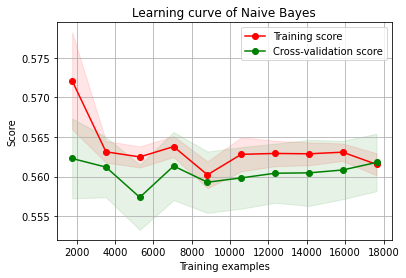

In [76]:
estimator=GaussianNB()
plot_cv_learning_curve(estimator, 'Learning curve of Naive Bayes', train_X, train_y, ylim=None, cv=5,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('fig/pdf/ingr_w2v_nb_lc.pdf',dpi=300,bbox_inches='tight')
plt.savefig('fig/png/ingr_w2v_nb_lc.png',dpi=300,bbox_inches='tight')

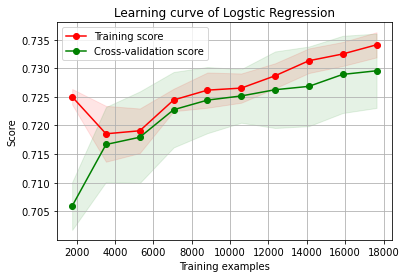

In [77]:
estimator=LogisticRegression(C=1000, multi_class='multinomial', random_state=9527,
                   solver='saga')
plot_cv_learning_curve(estimator, 'Learning curve of Logstic Regression', train_X, train_y, ylim=None, cv=5,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('fig/pdf/ingr_w2v_log_lc.pdf',dpi=300,bbox_inches='tight')
plt.savefig('fig/png/ingr_w2v_log_lc.png',dpi=300,bbox_inches='tight')

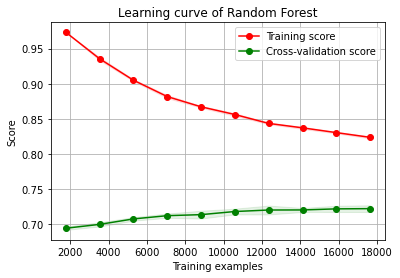

In [78]:
estimator=RandomForestClassifier(criterion='entropy', max_depth=10, max_features='auto',
                       random_state=42)
plot_cv_learning_curve(estimator, 'Learning curve of Random Forest', train_X, train_y, ylim=None, cv=5,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('fig/pdf/ingr_w2v_rf_lc.pdf',dpi=300,bbox_inches='tight')
plt.savefig('fig/png/ingr_w2v_rf_lc.png',dpi=300,bbox_inches='tight')

In [ ]:
# confusion matrix

In [79]:
def plot_confusion_matrix(cm,classes,title,normalize=False,cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,fontsize=14)
    plt.yticks(tick_marks, classes,fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=14)

    plt.ylabel('True label',fontsize=14)
    plt.xlabel('Predicted label',fontsize=14)
    plt.tight_layout()

In [81]:
log_cm=confusion_matrix(log_ypred,test_y)
np.set_printoptions(precision=2)

Normalized confusion matrix
[[0.78 0.13 0.09]
 [0.11 0.71 0.19]
 [0.1  0.21 0.69]]


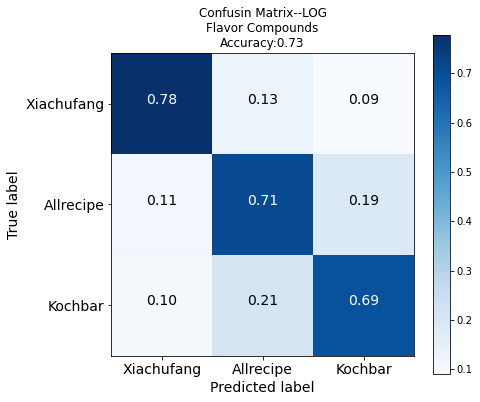

In [82]:
plt.figure(figsize=(7,6))
plot_confusion_matrix(log_cm,normalize=True,classes=['Xiachufang','Allrecipe','Kochbar'],
                      title='Confusin Matrix--LOG\nFlavor Compounds\nAccuracy:{0:.2f}'.format(accuracy_score(test_y,log_ypred)))
plt.savefig('fig/pdf/ingr_w2v_log_cm.pdf',dpi=300,bbox_inches='tight')
plt.savefig('fig/png/ingr_w2v_log_cm.png',dpi=300,bbox_inches='tight')